In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from typing import List, Dict, Set

# Flip 7 Simulation

Player 1 draws a card...
Drew: 9


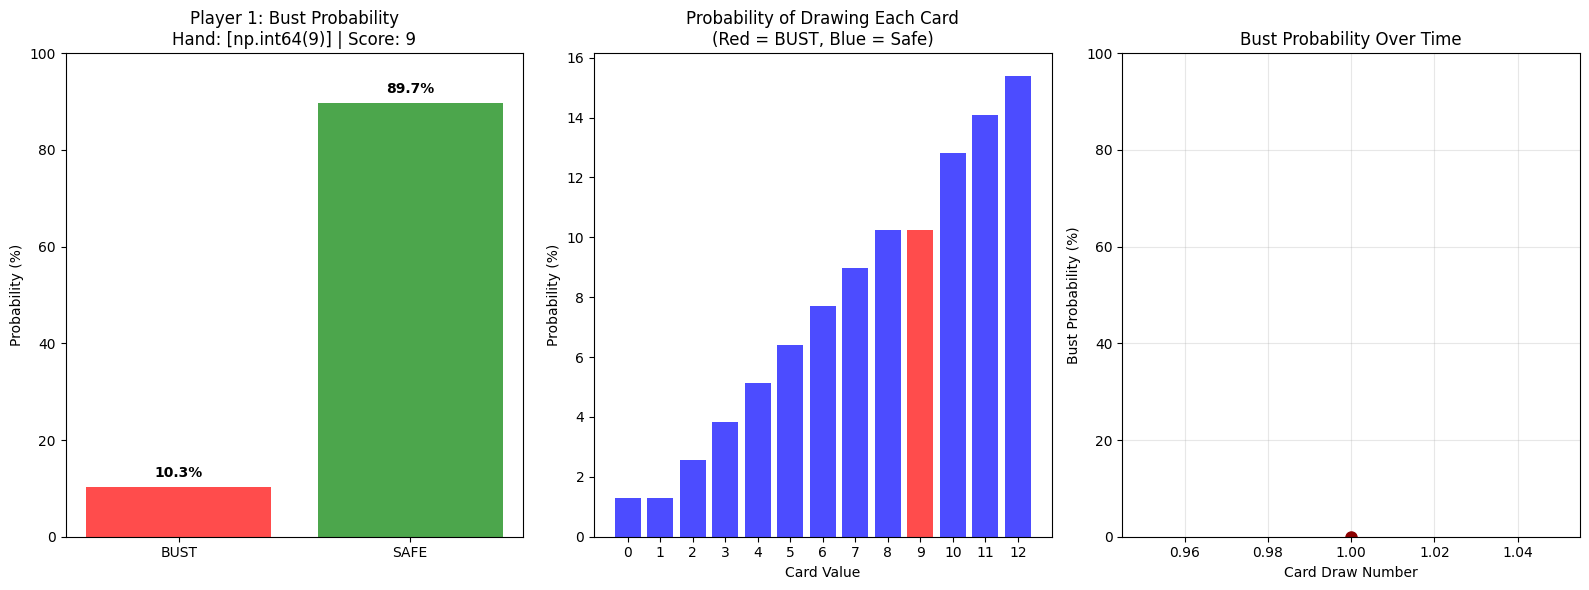


PLAYER 1 STATUS
Hand: [np.int64(9)]
Current Score: 9
Cards Remaining in Deck: 78
Cards that would BUST: 8 (10.3%)
Cards that are SAFE: 70 (89.7%)



In [28]:
class Flip7Game:
    def __init__(self, num_players: int = 4):
        self.num_players = num_players
        self.deck = self._create_deck()
        self.players = [{"hand": [], "score": 0, "busted": False, "bust_history": []} for _ in range(num_players)]
        self.drawn_cards = []
        
    def _create_deck(self) -> List[int]:
        """Create deck: 0 appears once, 1 appears once, 2 twice, ..., 12 twelve times"""
        deck = [0]  # One 0 card
        for value in range(1, 13):
            deck.extend([value] * value)
        return deck
    
    def reset_round(self):
        """Reset for a new round"""
        self.deck = self._create_deck()
        self.drawn_cards = []
        for player in self.players:
            player["hand"] = []
            player["busted"] = False
            player["bust_history"] = []
    
    def get_remaining_cards(self) -> Counter:
        """Count remaining cards in deck"""
        remaining = Counter(self.deck)
        for card in self.drawn_cards:
            remaining[card] -= 1
        return remaining
    
    def calculate_bust_probability(self, player_idx: int) -> Dict:
        """Calculate probability of busting for a specific player"""
        player = self.players[player_idx]
        player_hand = set(player["hand"])
        remaining = self.get_remaining_cards()
        
        total_remaining = sum(remaining.values())
        if total_remaining == 0:
            return {"bust_prob": 1.0, "safe_prob": 0.0, "card_probs": {}}
        
        # Count cards that would cause a bust (duplicates)
        bust_cards = sum(remaining[card] for card in player_hand if card in remaining)
        safe_cards = total_remaining - bust_cards
        
        bust_prob = bust_cards / total_remaining
        safe_prob = safe_cards / total_remaining
        
        # Probability for each card value
        card_probs = {value: count / total_remaining for value, count in remaining.items() if count > 0}
        
        return {
            "bust_prob": bust_prob,
            "safe_prob": safe_prob,
            "card_probs": card_probs,
            "total_remaining": total_remaining,
            "bust_cards": bust_cards,
            "safe_cards": safe_cards
        }
    
    def draw_card(self, player_idx: int) -> int:
        """Draw a card for a player"""
        if not self.deck:
            raise ValueError("Deck is empty!")
        
        player = self.players[player_idx]
        
        # Don't allow drawing if already busted
        if player["busted"]:
            print(f"❌ Player {player_idx + 1} has already BUSTED and cannot draw more cards!")
            return None
        
        # Record bust probability before drawing
        probs = self.calculate_bust_probability(player_idx)
        player["bust_history"].append(probs["bust_prob"])
        
        # Draw random card from remaining deck
        remaining = [card for card in self.deck if card not in self.drawn_cards or self.drawn_cards.count(card) < self.deck.count(card)]
        card = np.random.choice(remaining)
        
        self.drawn_cards.append(card)
        
        # Check for bust
        if card in player["hand"]:
            player["busted"] = True
            player["score"] = 0
            print(f"\n💥💥💥 PLAYER {player_idx + 1} BUSTED! 💥💥💥")
            print(f"Drew duplicate card: {card}")
            print(f"Final hand was: {player['hand'] + [card]}")
            print(f"Score: 0 points\n")
        else:
            player["hand"].append(card)
            player["score"] = sum(player["hand"])
        
        return card
    
    def visualize_probabilities(self, player_idx: int, figsize=(16, 6)):
        """Visualize bust probability and card probabilities for a player"""
        probs = self.calculate_bust_probability(player_idx)
        player = self.players[player_idx]
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=figsize)
        
        # Plot 1: Bust vs Safe probability (in %)
        if player["busted"]:
            ax1.bar(['BUST', 'SAFE'], [100, 0], color=['darkred', 'lightgray'], alpha=0.9)
            ax1.set_title(f'Player {player_idx + 1}: 💥 BUSTED 💥\nFinal Score: 0', 
                         fontsize=14, fontweight='bold', color='red')
        else:
            ax1.bar(['BUST', 'SAFE'], [probs['bust_prob'] * 100, probs['safe_prob'] * 100], 
                    color=['red', 'green'], alpha=0.7)
            ax1.set_title(f'Player {player_idx + 1}: Bust Probability\nHand: {player["hand"]} | Score: {player["score"]}')
            ax1.text(0, probs['bust_prob'] * 100 + 2, f'{probs["bust_prob"]*100:.1f}%', ha='center', fontweight='bold')
            ax1.text(1, probs['safe_prob'] * 100 + 2, f'{probs["safe_prob"]*100:.1f}%', ha='center', fontweight='bold')
        
        ax1.set_ylim(0, 100)
        ax1.set_ylabel('Probability (%)')
        
        # Plot 2: Probability of drawing each card (in %)
        if not player["busted"]:
            card_values = sorted(probs['card_probs'].keys())
            card_probabilities = [probs['card_probs'][v] * 100 for v in card_values]
            player_hand_set = set(player["hand"])
            colors = ['red' if v in player_hand_set else 'blue' for v in card_values]
            
            ax2.bar(card_values, card_probabilities, color=colors, alpha=0.7)
            ax2.set_xlabel('Card Value')
            ax2.set_ylabel('Probability (%)')
            ax2.set_title(f'Probability of Drawing Each Card\n(Red = BUST, Blue = Safe)')
            ax2.set_xticks(range(13))
        else:
            ax2.text(0.5, 0.5, '💥 BUSTED 💥', ha='center', va='center', 
                    transform=ax2.transAxes, fontsize=20, fontweight='bold', color='red')
            ax2.set_title('No More Draws Allowed')
            ax2.set_xticks([])
            ax2.set_yticks([])
        
        # Plot 3: Bust probability history over draws
        if len(player["bust_history"]) > 0:
            draws = list(range(1, len(player["bust_history"]) + 1))
            ax3.plot(draws, [p * 100 for p in player["bust_history"]], 
                    marker='o', linewidth=2, markersize=8, color='darkred')
            ax3.fill_between(draws, [p * 100 for p in player["bust_history"]], 
                           alpha=0.3, color='red')
            ax3.set_xlabel('Card Draw Number')
            ax3.set_ylabel('Bust Probability (%)')
            ax3.set_title('Bust Probability Over Time')
            ax3.set_ylim(0, 100)
            ax3.grid(True, alpha=0.3)
            
            # Add final bust indicator if busted
            if player["busted"]:
                ax3.axhline(y=100, color='red', linestyle='--', linewidth=2, alpha=0.5)
                ax3.text(len(draws), 95, '💥 BUST!', ha='right', fontsize=12, 
                        fontweight='bold', color='red')
        else:
            ax3.text(0.5, 0.5, 'No cards drawn yet', ha='center', va='center', 
                    transform=ax3.transAxes, fontsize=12)
            ax3.set_xlabel('Card Draw Number')
            ax3.set_ylabel('Bust Probability (%)')
            ax3.set_title('Bust Probability Over Time')
        
        plt.tight_layout()
        plt.show()
        
        # Print summary
        print(f"\n{'='*50}")
        if player["busted"]:
            print(f"💥 PLAYER {player_idx + 1} - BUSTED 💥")
        else:
            print(f"PLAYER {player_idx + 1} STATUS")
        print(f"{'='*50}")
        print(f"Hand: {player['hand']}")
        print(f"Current Score: {player['score']}")
        if not player["busted"]:
            print(f"Cards Remaining in Deck: {probs['total_remaining']}")
            print(f"Cards that would BUST: {probs['bust_cards']} ({probs['bust_prob']*100:.1f}%)")
            print(f"Cards that are SAFE: {probs['safe_cards']} ({probs['safe_prob']*100:.1f}%)")
        print(f"{'='*50}\n")

# Example usage
game = Flip7Game(num_players=4)

# Simulate Player 1 drawing some cards
print("Player 1 draws a card...")
card = game.draw_card(0)
print(f"Drew: {card}")
game.visualize_probabilities(0)

## Players drawing cards

Player 2 draws a card...

💥💥💥 PLAYER 2 BUSTED! 💥💥💥
Drew duplicate card: 10
Final hand was: [np.int64(5), np.int64(10), np.int64(10)]
Score: 0 points

Drew: 10


/var/folders/d6/tj0713yn5xb980x310wg01n80000gp/T/ipykernel_34103/458193633.py:162: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/mahiko.konishi/Library/Python/3.13/lib/python/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128165 (\N{COLLISION SYMBOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


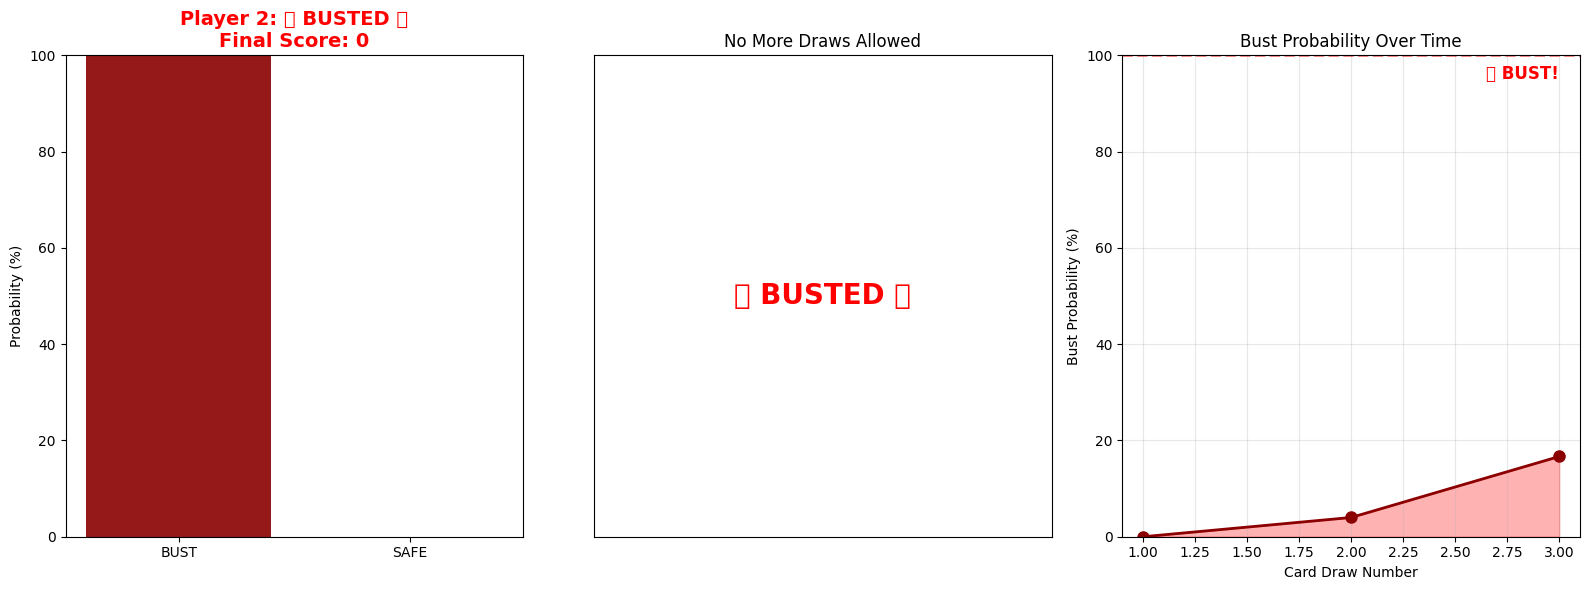


💥 PLAYER 2 - BUSTED 💥
Hand: [np.int64(5), np.int64(10)]
Current Score: 0



In [35]:
# Simulate Player drawing some cards
player_n = 2

print(f"Player {player_n} draws a card...")
card = game.draw_card(player_n - 1)
print(f"Drew: {card}")
game.visualize_probabilities(player_n - 1)

Player 3 draws a card...
Drew: 10


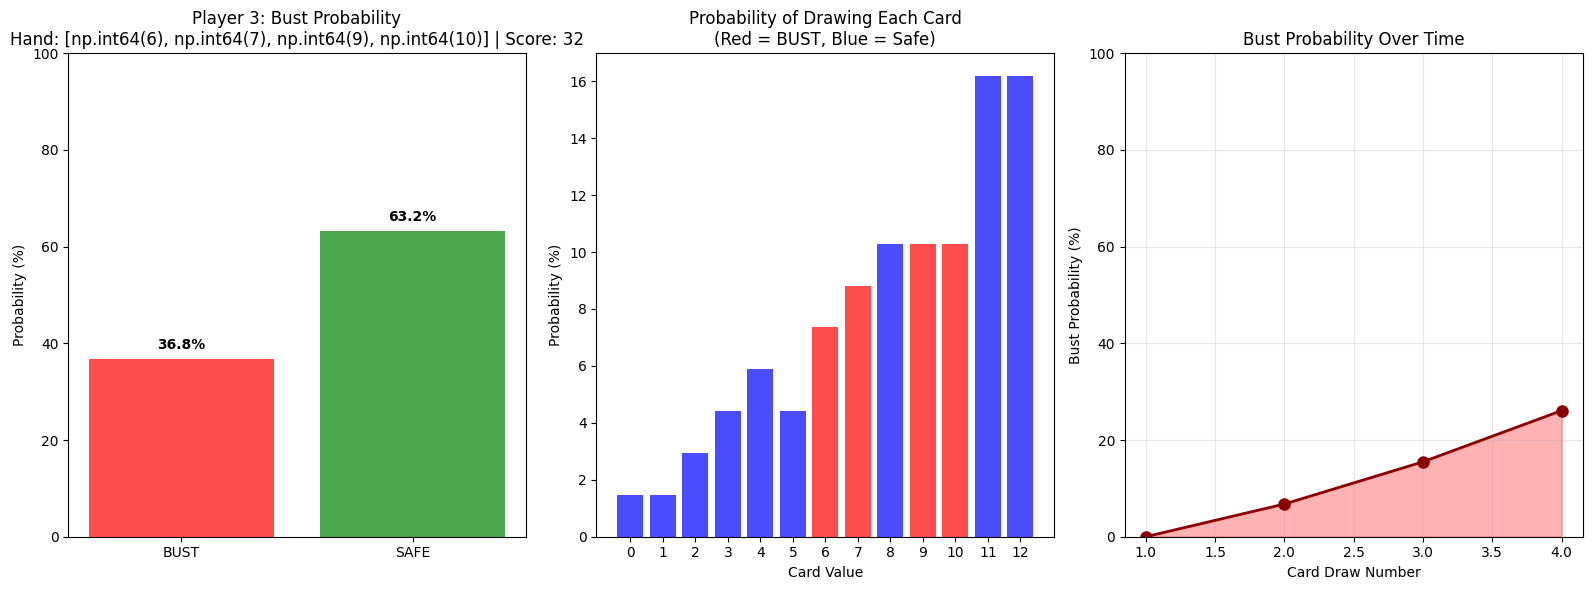


PLAYER 3 STATUS
Hand: [np.int64(6), np.int64(7), np.int64(9), np.int64(10)]
Current Score: 32
Cards Remaining in Deck: 68
Cards that would BUST: 25 (36.8%)
Cards that are SAFE: 43 (63.2%)



In [38]:
# Simulate Player 3 drawing some cards
player_n = 3
print(f"Player {player_n} draws a card...")
card = game.draw_card(player_n - 1)
print(f"Drew: {card}")
game.visualize_probabilities(player_n - 1)

Player 1 draws a card...
Drew: 11


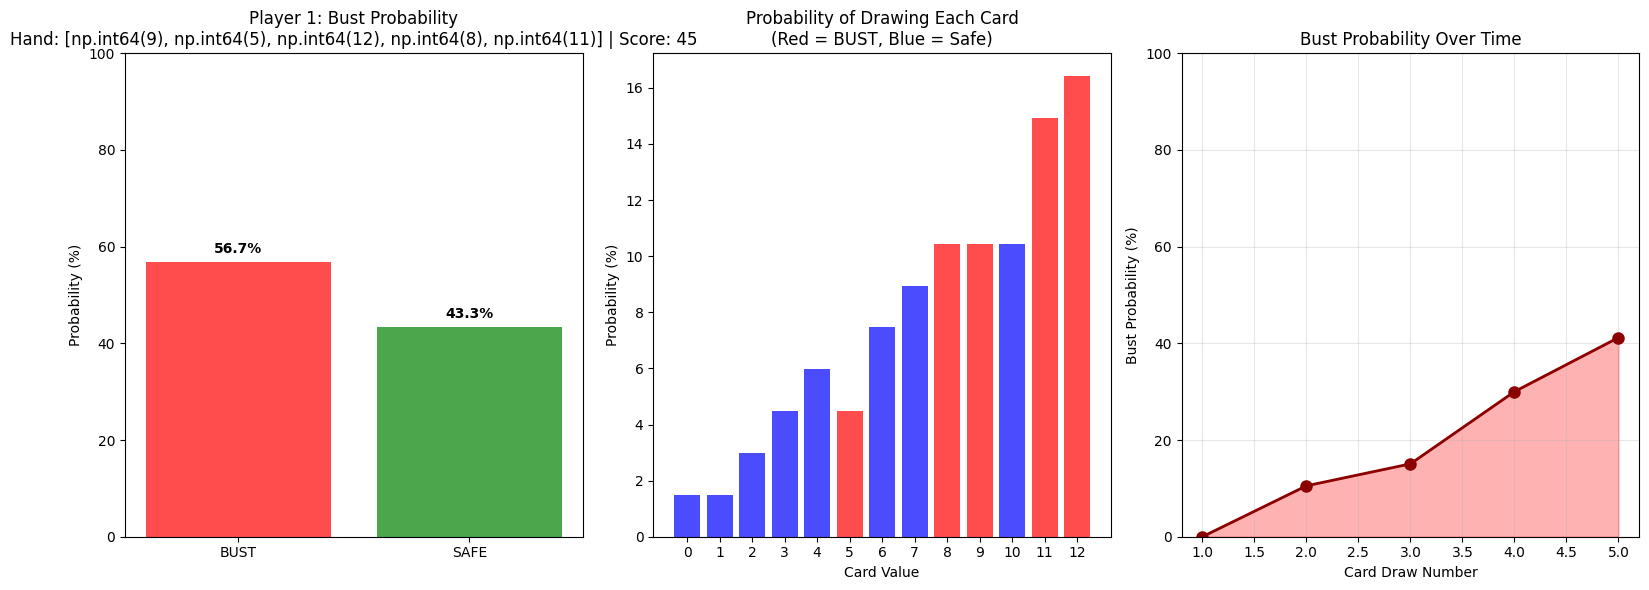


PLAYER 1 STATUS
Hand: [np.int64(9), np.int64(5), np.int64(12), np.int64(8), np.int64(11)]
Current Score: 45
Cards Remaining in Deck: 67
Cards that would BUST: 38 (56.7%)
Cards that are SAFE: 29 (43.3%)



In [39]:
# Simulate Player 1 drawing some cards
player_n = 1
print(f"Player {player_n} draws a card...")
card = game.draw_card(player_n - 1)
print(f"Drew: {card}")
game.visualize_probabilities(player_n - 1)

# Simulate first 2 cards

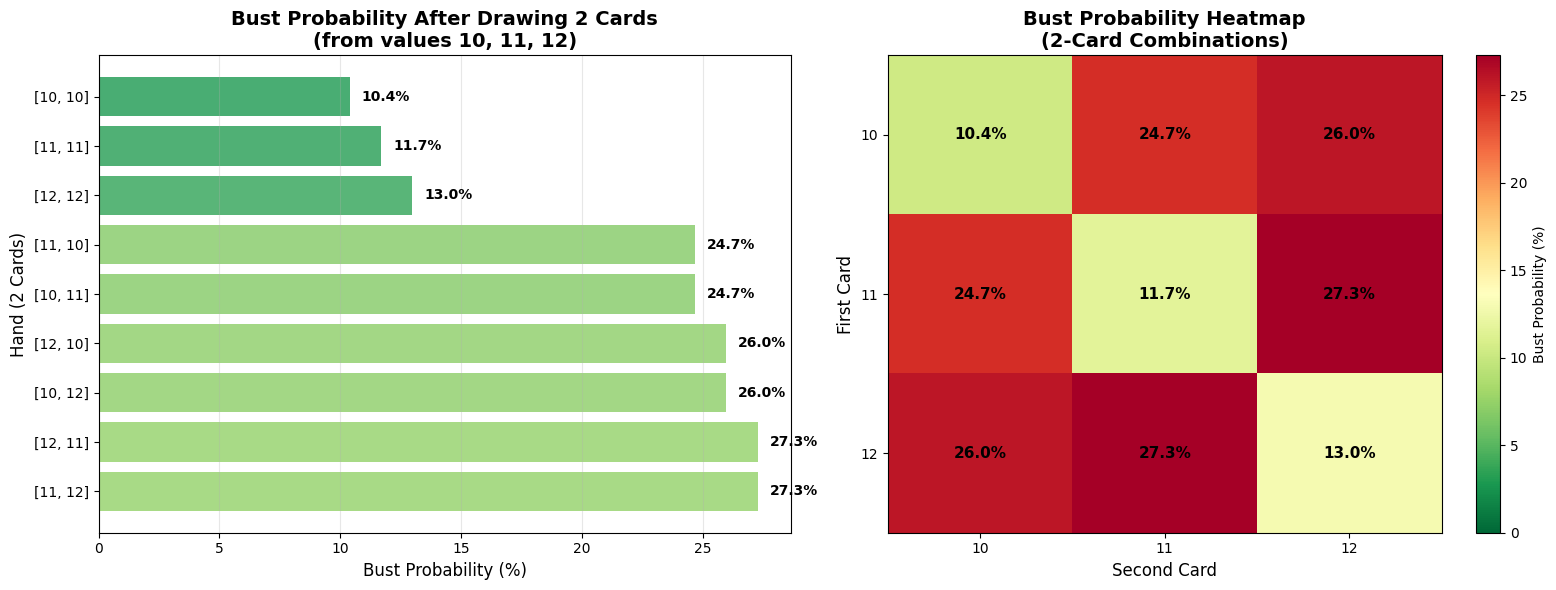


BUST PROBABILITY ANALYSIS - 2 CARD COMBINATIONS (10, 11, 12)
 card1  card2     hand  total  bust_prob  bust_cards  safe_cards
    11     12 [11, 12]     23  27.272727          21          56
    12     11 [12, 11]     23  27.272727          21          56
    10     12 [10, 12]     22  25.974026          20          57
    12     10 [12, 10]     22  25.974026          20          57
    10     11 [10, 11]     21  24.675325          19          58
    11     10 [11, 10]     21  24.675325          19          58
    12     12 [12, 12]     24  12.987013          10          67
    11     11 [11, 11]     22  11.688312           9          68
    10     10 [10, 10]     20  10.389610           8          69


In [41]:
# Analysis: Bust probability after drawing 2 specific cards

def analyze_two_card_bust_probability():
    """Analyze bust probability after drawing any 2-card combination from [10, 11, 12]"""
    
    from itertools import combinations_with_replacement
    
    cards_to_test = [10, 11, 12]
    results = []
    
    # Generate all possible 2-card combinations (including duplicates like [10,10])
    for card1 in cards_to_test:
        for card2 in cards_to_test:
            # Create a new game
            test_game = Flip7Game(num_players=1)
            
            # Manually set the player's hand
            test_game.players[0]["hand"] = [card1, card2]
            test_game.players[0]["score"] = card1 + card2
            
            # Mark these cards as drawn
            test_game.drawn_cards = [card1, card2]
            
            # Calculate bust probability
            probs = test_game.calculate_bust_probability(0)
            
            results.append({
                'card1': card1,
                'card2': card2,
                'hand': f"[{card1}, {card2}]",
                'total': card1 + card2,
                'bust_prob': probs['bust_prob'] * 100,
                'bust_cards': probs['bust_cards'],
                'safe_cards': probs['safe_cards']
            })
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Create visualization
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot 1: Bar chart of bust probability for each combination
    df_sorted = df.sort_values('bust_prob', ascending=False)
    colors = plt.cm.RdYlGn_r(df_sorted['bust_prob'] / 100)
    
    ax1.barh(range(len(df_sorted)), df_sorted['bust_prob'], color=colors, alpha=0.8)
    ax1.set_yticks(range(len(df_sorted)))
    ax1.set_yticklabels(df_sorted['hand'])
    ax1.set_xlabel('Bust Probability (%)', fontsize=12)
    ax1.set_ylabel('Hand (2 Cards)', fontsize=12)
    ax1.set_title('Bust Probability After Drawing 2 Cards\n(from values 10, 11, 12)', 
                  fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)
    
    # Add percentage labels
    for i, (idx, row) in enumerate(df_sorted.iterrows()):
        ax1.text(row['bust_prob'] + 0.5, i, f"{row['bust_prob']:.1f}%", 
                va='center', fontsize=10, fontweight='bold')
    
    # Plot 2: Heatmap showing bust probability by card combination
    pivot_data = df.pivot_table(values='bust_prob', index='card1', columns='card2', aggfunc='first')
    
    # Fix: Use .max().max() to get the actual maximum value
    im = ax2.imshow(pivot_data, cmap='RdYlGn_r', aspect='auto', vmin=0, vmax=pivot_data.max().max())
    
    # Set ticks
    ax2.set_xticks(range(len(cards_to_test)))
    ax2.set_yticks(range(len(cards_to_test)))
    ax2.set_xticklabels(cards_to_test)
    ax2.set_yticklabels(cards_to_test)
    ax2.set_xlabel('Second Card', fontsize=12)
    ax2.set_ylabel('First Card', fontsize=12)
    ax2.set_title('Bust Probability Heatmap\n(2-Card Combinations)', 
                  fontsize=14, fontweight='bold')
    
    # Add text annotations
    for i in range(len(cards_to_test)):
        for j in range(len(cards_to_test)):
            text = ax2.text(j, i, f'{pivot_data.iloc[i, j]:.1f}%',
                          ha="center", va="center", color="black", fontsize=11, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax2)
    cbar.set_label('Bust Probability (%)', fontsize=10)
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed table
    print("\n" + "="*70)
    print("BUST PROBABILITY ANALYSIS - 2 CARD COMBINATIONS (10, 11, 12)")
    print("="*70)
    print(df_sorted.to_string(index=False))
    print("="*70)
    
    return df

# Run the analysis
df_results = analyze_two_card_bust_probability()